# Analítica de datos - ejemplo de clase lfw_people - comparación distintos métodos de clasificación - Ejecución sobre Google Colaboratory

https://d2l.ai/

### Se declaran las funciones principales a utilizar sobre el cuaderno

In [3]:
import os
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
from sklearn.base import  BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA 
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import keras

#rom keras.optimizers import Adam
#from keras.utils import plot_model
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.layers.advanced_activations import LeakyReLU

In [4]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"


# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

###Paso 1: Lectura

In [5]:
from sklearn.impute import SimpleImputer 
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline

#base de datos
from sklearn.datasets import fetch_lfw_people
#https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html

%matplotlib inline
#descargar base de datos
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

Xtrain Shape = (901, 50, 37) , Xtest Shape = (387, 50, 37)


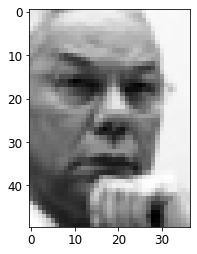

In [11]:
Xdata = lfw_people.images/255
y = lfw_people.target

Xtrain, Xtest, ytrain, ytest = train_test_split(Xdata,y,test_size=0.3)
print(f"Xtrain Shape = {Xtrain.shape} , Xtest Shape = {Xtest.shape}")
plt.imshow(Xtrain[90],cmap='gray')

## Generar Entradas y Salidas:

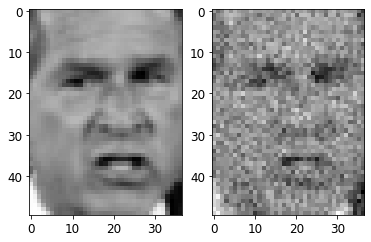

In [ ]:
#agregar entrada extra 
var = 0.01 #varianza ruido
XtrainB = Xtrain + np.sqrt(var)*np.random.randn(Xtrain.shape[0],Xtrain.shape[1],Xtrain.shape[2])
XtestB = Xtest + np.sqrt(var)*np.random.randn(Xtest.shape[0],Xtest.shape[1],Xtest.shape[2])

#ejemplo entrada con y sin ruido
fig, ax = plt.subplots(1,2)
fig.figsize = (4,4)
ax[0].imshow(Xtrain[0],cmap='gray')
ax[1].imshow(XtrainB[0],cmap='gray')
plt.show()

A continuación creo el modelo:

* Inicio definiendo las entradas, las cuales son cada una un tensor en $4D$, las cuales son (none, 50, 37, 1) donde 50 y 37 representan la cantidad de pixeles y el 1 representa los canales de la imagen, en este caso se usa el 1 por ser a blanco y negro (La segunda entrada es igual a la primera + ruido).
* Ahora defino una capa convolucional de 64 neuronas para cada entrada.
* Defino una capa de MaxPooling para cada capa convolucional.
* Agrego 2 capas con 128 neuronas cada una para cada lado de la red (cada entrada) junto con un nuevo MaxPooling para cada una.
* Ahora agrego capas densas con activación 'relu' ya que fue la que me dio mejor rendimiento para este ejercicio junto con algunas de dropout con una relación de on-off del 50%.
* Por ultimo se concatenan las redes que teníamos y se llevan a nuestra única salida. 

In [ ]:
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1,
                           padding="SAME", activation="relu")

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
entradaB (InputLayer)           [(None, 50, 37, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 50, 37, 32)   320         entradaB[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 50, 37, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 25, 18, 32)   0           conv2d_3[0][0]                   
_______________________________________________________________________________________

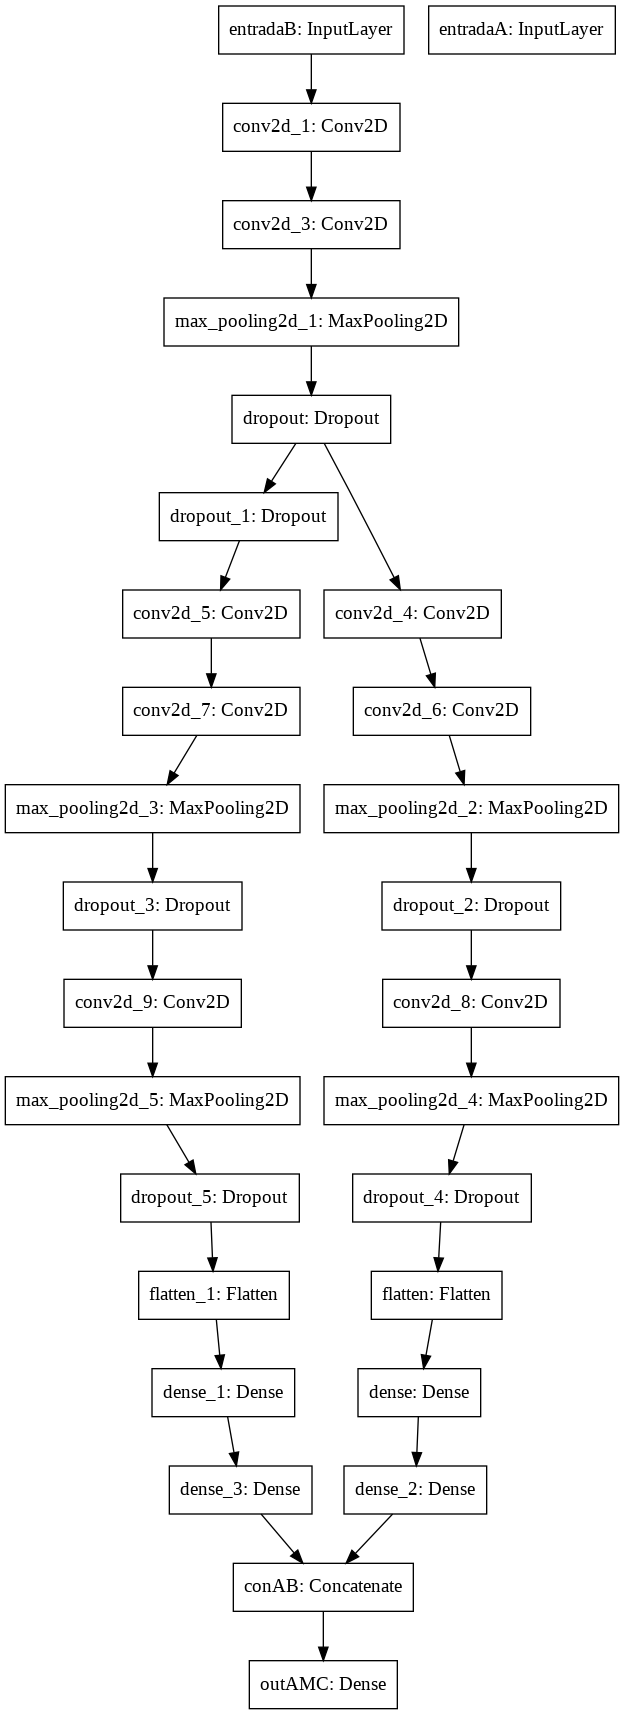

In [ ]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

tf.keras.backend.clear_session()

inputA = tf.keras.layers.Input(shape=(Xtrain.shape[1],Xtrain.shape[2],1), name='entradaA')
inputB = tf.keras.layers.Input(shape=(XtrainB.shape[1],XtrainB.shape[2],1), name='entradaB')

flattenA = Conv2D(32, (3, 3), padding =
      'same', activation = 'relu',
      input_shape = (28, 28, 1))(inputA)
flattenB = Conv2D(32, (3, 3), padding =
      'same', activation = 'relu',
      input_shape = (28, 28, 1))(inputB)

flattenC = Conv2D(32, (3, 3), padding =
      'same', activation = 'relu',
      input_shape = (28, 28, 1))(flattenA)
flattenD = Conv2D(32, (3, 3), padding =
      'same', activation = 'relu',
      input_shape = (28, 28, 1))(flattenB)


AB = MaxPooling2D(pool_size = (2,
          2), strides = None,
      padding = 'valid',
      data_format = None)(flattenC)
CD = MaxPooling2D(pool_size = (2,
          2), strides = None,
      padding = 'valid',
      data_format = None)(flattenD)


D1 = Dropout(0.25)(CD)
D2 = Dropout(0.25)(D1)


h1A = Conv2D(64, (3, 3), padding =
      'same', activation = 'relu',
      input_shape = (28, 28, 1))(D1)
h1B = Conv2D(64, (3, 3), padding =
      'same', activation = 'relu',
      input_shape = (28, 28, 1))(D2)

h1C = Conv2D(64, (3, 3), padding =
      'same', activation = 'relu',
      input_shape = (28, 28, 1))(h1A)
h1D = Conv2D(64, (3, 3), padding =
      'same', activation = 'relu',
      input_shape = (28, 28, 1))(h1B)


M1 = MaxPooling2D(pool_size = (2,
          2), strides = None,
      padding = 'valid',
      data_format = None)(h1C)
M2 = MaxPooling2D(pool_size = (2,
          2), strides = None,
      padding = 'valid',
      data_format = None)(h1D)


D3 = Dropout(0.25)(M1)
D4 = Dropout(0.25)(M2)


flattenJ = Conv2D(128, (3, 3), padding =
      'same', activation = 'relu',
      input_shape = (28, 28, 1))(D3)
flattenK = Conv2D(256, (3, 3), padding =
      'same', activation = 'relu',
      input_shape = (28, 28, 1))(D4)

A = MaxPooling2D(pool_size = (2,
          2), strides = None,
      padding = 'valid',
      data_format = None)(flattenJ)
A1 = MaxPooling2D(pool_size = (2,
          2), strides = None,
      padding = 'valid',
      data_format = None)(flattenK)


B = Dropout(0.25)(A)
B1 = Dropout(0.25)(A1)

C = Flatten()(B)
C1 = Flatten()(B1)

D = Dense(256, input_shape = (256, ), activation='relu')(C)
D1 = Dense(256, input_shape = (256, ), activation='relu')(C1)

E = Dense(10)(D)
E1 = Dense(10)(D1)

concAB = tf.keras.layers.concatenate([E,E1],name='conAB')

outputA = tf.keras.layers.Dense(10,activation="softmax",name='outAMC')(concAB) #salida multiclase
model_fun = tf.keras.Model(inputs=[inputA,inputB],outputs=[outputA])
model_fun.summary()
tf.keras.utils.plot_model(model_fun)

###Compilar modelo y entrenar

Para el history tomo 60 epocas ya que con 30 no rendía suficientemente bien el modelo y lotes de 64. 

In [ ]:
model_fun.compile(loss=["sparse_categorical_crossentropy"], #custom_loss(),#custom_loss(),#"sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              metrics=["accuracy"]) #f1, precision, recall, crossentropy
history = model_fun.fit(x =[Xtrain,XtrainB], y=ytrain, 
                        epochs=60,batch_size=128, # 32, 64, 128, 256
                         validation_split=0.3)

Epoch 1/60
5/5 [==============================] - 1s 122ms/step - loss: 1.9351 - accuracy: 0.3397 - val_loss: 1.9985 - val_accuracy: 0.3911
Epoch 2/60
5/5 [==============================] - 0s 34ms/step - loss: 1.7635 - accuracy: 0.4095 - val_loss: 1.8338 - val_accuracy: 0.3911
Epoch 3/60
5/5 [==============================] - 0s 34ms/step - loss: 1.7210 - accuracy: 0.4095 - val_loss: 1.8484 - val_accuracy: 0.3911
Epoch 4/60
5/5 [==============================] - 0s 33ms/step - loss: 1.7145 - accuracy: 0.4095 - val_loss: 1.8052 - val_accuracy: 0.3911
Epoch 5/60
5/5 [==============================] - 0s 34ms/step - loss: 1.7067 - accuracy: 0.4095 - val_loss: 1.8204 - val_accuracy: 0.3911
Epoch 6/60
5/5 [==============================] - 0s 34ms/step - loss: 1.6973 - accuracy: 0.4095 - val_loss: 1.7572 - val_accuracy: 0.3911
Epoch 7/60
5/5 [==============================] - 0s 34ms/step - loss: 1.6687 - accuracy: 0.4111 - val_loss: 1.7882 - val_accuracy: 0.3911
Epoch 8/60
5/5 [==========

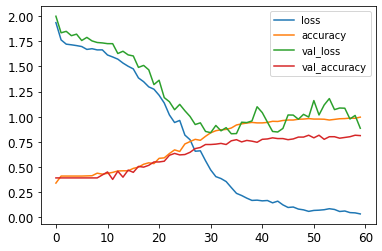

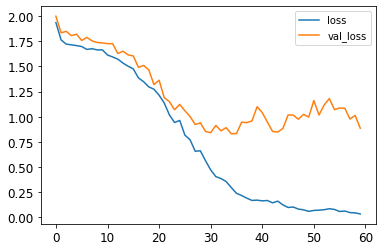

In [ ]:
#graficar historial convergencia
import pandas as pd
hpd = pd.DataFrame(history.history)
hpd.plot()
plt.show()
hpd[['loss','val_loss']].plot()
plt.show()

###Matriz de confusion

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = 100*cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

(387, 10)
              precision    recall  f1-score   support

           0       0.67      0.67      0.67        18
           1       0.89      0.86      0.87        69
           2       0.72      0.68      0.70        34
           3       0.88      0.91      0.90       166
           4       0.66      0.74      0.70        31
           5       0.88      0.74      0.80        19
           6       0.78      0.76      0.77        50

    accuracy                           0.83       387
   macro avg       0.78      0.76      0.77       387
weighted avg       0.83      0.83      0.83       387



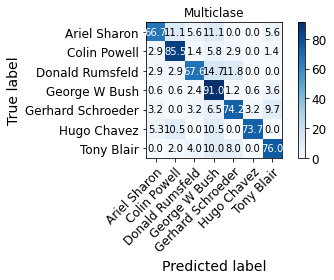

In [ ]:
#conjunto de test 
ytest_e = model_fun.predict([Xtest,XtestB])
print(ytest_e.shape)
plot_confusion_matrix(ytest, ytest_e.argmax(axis=1),classes=lfw_people.target_names)
plt.title('Multiclase')
print(classification_report(ytest, ytest_e.argmax(axis=1)))

En la matriz anterior se puede observar que el rendimiento de la red es bueno ya que para cada rostro se obtiene un % bastante alto, siendo el minimo de 64.5% y llegando hasta valores > 95%. Además alcanzando valores de accuracy de hasta 90%.

Comparando con las matrices obtenidas por Clasificador Logistico y SVM lineal podemos decir que la red tuvo un rendimiento un poco superior, ya que el accuracy para todos los casos fue superior y los porcentajes de acierto por cada etiqueta son bastante mayores (teniendo en las otras valores cercanos e inferiores al 50%).